## Гипотезы

1. Для успешных проектов
- больше комментов => больше денег 

2. Для всех проектов
- Проекты, отмеченные тегами, собирают больше денег чем проекты без тэгов
- больше апдейтов => больше комментов 
- больше ревардов  => больше pledge 
- глаголы побуждения повышают average pledge
- чем выше sentiment_score, тем выше average pledge
- если вы в лондоне, то average pledge больше 
- pledge для тэга community будет больше, чем для всех остальных
- количество supporters для национальных проектов больше, чем в локальных

3. Количество денег имеет экспоненциальное распределение

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_pickle('df_hyp.pkl') # считаем данные из основного файла
df.head()

,href,title,description,location,tags,upd,comm,supp,rewards_num,money,...,tags_Transport,tags_Travel,tags_University,tags_Venue,tags_null,sentiment_score,ps_capital,inn_score,eco_score,pledge
0,https://www.crowdfunder.co.uk/free-assange,Help campaign to Free Julian Assange,"[help, campaign, free, julian, assange, stop, ...",London,"[Community, Personal Causes]",22,1242,3576,0,300000.0,...,0,0,0,0,0,0.7840,0,0,0,83.892617
1,https://www.crowdfunder.co.uk/blackout2023,Black Out 2023 | Cannes Lions Festival,"[taking, black, talent, connected, creative, i...",London,"[Business, Music]",0,9,24,0,100000.0,...,0,0,0,0,0,0.9217,0,2,0,4166.666667
2,https://www.crowdfunder.co.uk/50-days-to-make-...,50 Days to Make a Difference,"[scientists, curate, portfolio, effective, cli...",London,[Environment],0,11,68,3,150000.0,...,0,0,0,0,0,0.7430,1,0,2,2205.882353
3,https://www.crowdfunder.co.uk/saveside,#SAVESIDE,"[april, side, gallery, close, public, due, cri...",Newcastle upon Tyne,[Creative & Arts],5,694,1806,0,75000.0,...,0,0,0,0,0,-0.7096,0,0,0,41.528239
4,https://www.crowdfunder.co.uk/lets-smash-the-p...,Let's smash the political silence on Brexit,"[everyone, knows, brexit, working, politicians...",London,[Politics],1,407,2391,6,100000.0,...,0,0,0,0,0,0.0000,0,0,0,41.823505


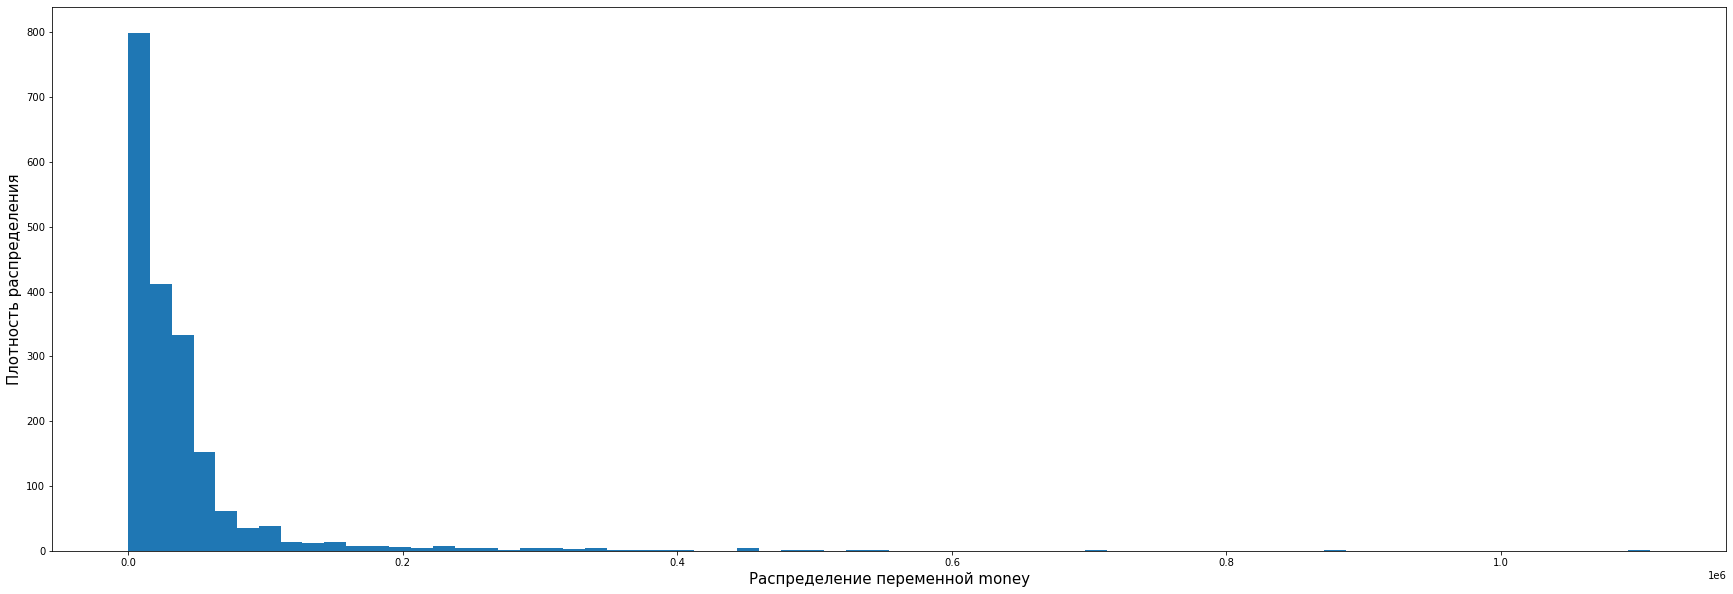

In [10]:
f, ax = plt.subplots(figsize=(30,10))
plt.ylabel("Плотность распределения", fontsize=15)
plt.xlabel("Распределение переменной money", fontsize=15)
plt.hist(df['money'], bins=70);

В ходе работы мы выяснили, что есть 4 проекта, у которых 0 supporters, что необъяснимо с точки зрения логики, поэтому при расчете среднего мы их не учитывали :)

Также можно увидеть, что в данных по деньгам присутствует довольно большое количество выбросов, поэтому при проверке гипотез мы будем пользоваться несколькими методами: проведение асимптотического ztest'а и бустрап теста с удалением выбросов, тест Манна-Уитни, который самостоятельно работает с выбросами, оценка медиан без удаления выбросов с помощью бутстрапа

Выбросами будем считать проекты, у которых средний взнос больше 2000 долларов

Также отметим, что национальными называются те проекты, у которых в переменнной локация записано United Kingdom. Это проекты, которые направлены на достижение каких-то реальных целей по всей стране. Например, сбор денег для благотворительных организаций, связанных  предоставлением жилья, обеспечение едой школьников и т.д.

#### Будем проверять гипотезы на уровне значимости $\alpha = 0.05$

Предварительно напишем функции, необходимые для проверки гипотез: получение бутстрап выборок, построение интервалов и перестановочный тест

Код для бутстрапа взят с семинара 13: https://github.com/hse-econ-data-science/andan_2023/blob/main/sem13_bootstrap/sem13_python_bootstrap.ipynb

Функция, создающая бут-выборку

In [58]:
def get_bootstrap_sample(x, B_sample=1):
    np.random.seed(1000)
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

Функция, создающая доверительный интервал

In [59]:
def quantile_ci(x_boot, alpha=0.05):
    left = np.quantile(x_boot, alpha/2)
    right = np.quantile(x_boot, 1-alpha/2)
    return left, right

Функция, создающая выборки для перестановочного теста и считающая корреляию

In [47]:
def permutation_test(x, y, alpha=0.05, n_sim = 10 ** 4):
    np.random.seed(1000)
    corr = []
    corr_new = 0
    for i in range(n_sim):
        x_perm = np.random.permutation(x)
        corr_new = sts.pearsonr(x_perm, y)[0]
        corr.append(corr_new)
    return corr

## Гипотеза о связи между количеством комментариев и собранным количеством денег

Можно предположить, что чем больше комментариев оставляют люди к проекту, тем больше они вовлечены в данный проект и заинтересованы в нем. Значит, они могут вкладывать в него больше денег, что позволяет проекту в целом собрать бОльшую сумму

Также имеет смысл рассматривать эту гипотезу только для завершенных проектов, так как для текущих в колонке money отмечена их цель и делать выводы о финальном результате будет некорректно

In [550]:
supp_suc = df[df['status'] == 'success']['supp']
mon_suc = df[df['status'] == 'success']['money']
corr = np.corrcoef(supp_suc, mon_suc)[0][1]
corr

0.4282405945225073

Проверим уровень значимости этого коэффициента корреляции. Для этого найдем t-статистику

In [551]:
t_obs = corr * np.sqrt (supp_suc.size - 2) / np.sqrt(1 - corr ** 2)
t_obs

15.652829816875727

In [552]:
t_cr = sts.t.ppf(0.95, supp_suc.size - 2)
t_cr

1.6462514928708307

Вывод: как видно, t наблюдаемое больше t критического, значит, нулевая гипотеза о корреляции, равной нулю, отвергается, то есть между переменными действительно есть линейная положительная связь - чем больше комментариев оставляют пользователи, тем больше денег собирает проект

## Гипотеза о сборе денег проектами с тэгами и без тэгов

$$
\begin{aligned}
& H_0: \mu_{tags} = \mu_{without} \\
& H_1: \mu_{tags} > \mu_{without}
\end{aligned}
$$

Проверим данную гипотезу с помощью z-теста, удалив выбросы

In [12]:
with_tags = df[(df['tags_null'] == 0) & (df['supp'] != 0) & (df['pledge'] < 2000)]['pledge']
without_tags = df[(df['tags_null'] == 1) & (df['supp'] != 0)  & (df['pledge'] < 2000)]['pledge']
with_tags.size, without_tags.size

(1813, 48)

In [335]:
with_tags.mean()

235.60029179378677

In [336]:
without_tags.mean()

156.0329529991317

Посмотрим на распределение переменных чтобы понять, какой тест лучше использовать для проверки гипотезы (проверим распределение через тест Колмагорова)

In [13]:
sts.kstest(with_tags, 'norm')

KstestResult(statistic=0.9992709083294831, pvalue=0.0)

In [14]:
sts.kstest(without_tags, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

Видим, что распределение не похоже на нормальное, поэтому можем применить асимптотический ztest

In [337]:
from statsmodels.stats.weightstats import ztest
ztest(with_tags, without_tags, alternative = 'larger')

(1.6944055881069486, 0.045094119193359365)

Как видно, p-value меньше 0.05, значит, нулевая гипотеза отвергается и в проекты с тэгами действительно инвестируют больше, чем в проекты без тэгов. Это вполне логично, так как тэги дают представления инвесторам о тематике проекта,такие проекты более понятные, поэтому люди склонные инвестировать в них больше

## Гипотеза о связи количества апдейтов и количества комментариев в проекте

Так как комментарии и апдейты это, своего рода, коммуникация между организатором проекта и инвесторами, то можно предположить, что чем больше апдейтов оставляет организатор, чем чаще он обновляет информацию по проекту или каким-либо образом взаимодействует с людьми, то тем больше последние будут более склонны к обратной связи для инвестора в виде комментариев и наоборот

Проверим гипотезу через перестановочный тест

In [48]:
upd = df[(df['upd'] < 20) & (df['comm'] < 500)]['upd'] # удалим выбросы из данных
comm = df[(df['upd'] < 20) & (df['comm'] < 500)]['comm']
corr_perm = permutation_test(upd, comm)

In [388]:
upd.size, comm.size

(1800, 1800)

In [49]:
corr_hat = sts.pearsonr(upd, comm)[0]
corr_hat

0.3315355157374541

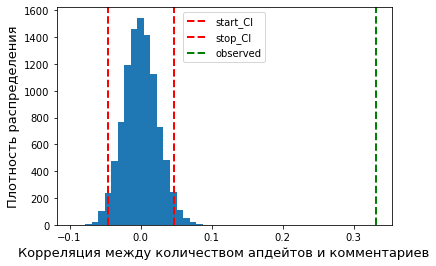

In [50]:
plt.hist(corr_perm, bins = 20);
plt.axvline(np.percentile(corr_perm, 2.5), color='red', linestyle="--", lw=2, label='start_CI')
plt.axvline(np.percentile(corr_perm, 97.5), color='red', linestyle="--", lw=2, label='stop_CI')
plt.axvline(corr_hat, color='green', linestyle="--", lw=2, label='observed')
plt.ylabel("Плотность распределения", fontsize=13)
plt.xlabel("Корреляция между количеством апдейтов и комментариев", fontsize=13)
plt.legend();

По графику видно, что выборочная корреляция не попадает в интервал, значит, нулевая гипотеза о наличии связи отвергается и на самом деле корреляция равна нулю, то есть линейной связи между количеством апдейтов и комментариев нет

## Гипотеза о связи количества наград и уровнем взноса
В целом в краудфандинге виды наград значительно различаются, однако многие зависят от того, какую сумму человек вкладывает в проект. Например, в проекте, направленном на переработку пластика с пляжей, за взнос в 20 долларов можно получить набор пластиковых чайников, за 35 - два набора, за 100 - 5 и т.д. Можно предположить, что чем больше наград предлагает организатор, тем больше мотивации будет у человека вкладывать большую сумму, так как он может получить какую-либо награду

In [107]:
from scipy.stats import pearsonr
pledge_rew = df[df['supp'] != 0]
res_pear = pearsonr(pledge_rew['rewards_num'], pledge_rew['pledge'])
res_pear

(-0.0364535920225099, 0.10819593557790556)

Вывод: как показывает тест, между данными на самом деле отсутствует корреляция, то есть можно сказать, что инвесторам не очень важно количество наград при выборе вкладывается в проект или нет

## Гипотеза о глаголах, побуждающих к действию, и pledge
Мы предполагаем, что на выбор человека о размере инвестиции может влиять и то, с каким посылом он видит описание проекта. Гипотеза состоит в том, что если инвестор видит какие-либо побуждающие глаголы, то он готов инвестировать в этот проект больше, так как он видит его значимость и предполагает, что его личное участие может повлиять на результат. 

In [111]:
# из кода по обработке описаний
common200 = pd.Series(df['description'].explode()).value_counts()[:200] 
common200.nlargest(10)

help         551
community    314
support      289
raise        282
new          209
need         207
funds        196
people       168
money        168
raising      166
Name: description, dtype: int64

Как видно, наиболее часто встречающиеся побуждающие глаголы из списка - это 'help', 'support', 'raise', 'need'. Проверим, влияют ли они на инвесторов

Нулевая гипотеза состоит в том, что матожидание группы проектов, в названии которых есть выбранные слова, равно группе проектов без этих слов. Альтернативная гипотеза - матожидание первой группы больше

$$
\begin{aligned}
& H_0: \mu_{words} = \mu_{without} \\
& H_1: \mu_{words} > \mu_{without}
\end{aligned}
$$

Для начала разобьем проекты на две группы: в описании которых есть ключевые слова и в которых их нет

Для этого создадим список с интересующими нас словами, оставим в колонке с описаниями только эти слова (получится список из тих слов) и посмотрим, где список не пустой - это будет группа с нужными словами

In [8]:
words = ['help', 'support', 'raise', 'need']
df_group_with = df[(df['supp'] != 0)][['description', 'pledge']]
df_group_with.description = df_group_with.description.apply(lambda x: [item for item in x if item in words])
df_group_with.description = df_group_with.description.apply(lambda x: len(x) > 0)
df_group_with_f = df_group_with[df_group_with['description'] == True]
df_group_without = df_group_with[df_group_with['description'] == False]
df_group_with.head()

,description,pledge
0,True,83.892617
1,False,4166.666667
2,False,2205.882353
3,True,41.528239
4,False,41.823505


In [9]:
pledge_with = df_group_with_f['pledge']
pledge_without = df_group_without['pledge']

In [10]:
pledge_with.mean()

1053.984270278861

In [11]:
pledge_without.mean()

674.3000411663126

Проведем тест Манна-Уитни для проверки равенства матожиданий (мы не удаляли выбросы, а данный тест умеет с ними работать). 

In [563]:
U, pval = sts.mannwhitneyu(pledge_with, pledge_without, alternative='greater')
U, pval

(438324.5, 0.9966870010169708)

Как видно, p-value стремится к 1, значит, нет оснований отвергать нулевую гипотезу, то есть матожидания равны и на самом деле слова в описании не влияют на решение инвестора о сумме взноса

## Гипотеза о связи между эмоциональной окраской и средним взносом

Как известно, в маркетинге, да и просто для привлечения внимания людей, часто используют "громкие", эмоциональные слова, что может сильно влиять на выбор человека. Мы хотим проверить, влияет ли эмоциональная окраска проекта в краудфандинге на желание человека инвестировать в него через перестановочный тест

In [51]:
pledge_all = df[df['supp'] != 0]['pledge']
sent_sc = df[df['supp'] != 0]['sentiment_score']

In [54]:
corr_hat2 = sts.pearsonr(pledge_all, sent_sc)[0]
corr_hat2

-0.0036769263482370257

In [55]:
corr_perm2 = permutation_test(pledge_all, sent_sc)

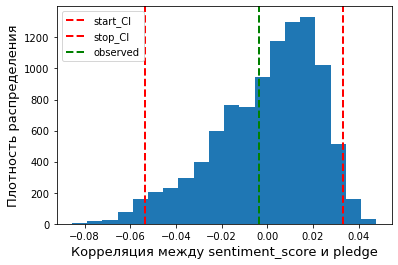

In [57]:
plt.hist(corr_perm2, bins = 20);
plt.axvline(np.percentile(corr_perm2, 2.5), color='red', linestyle="--", lw=2, label='start_CI')
plt.axvline(np.percentile(corr_perm2, 97.5), color='red', linestyle="--", lw=2, label='stop_CI')
plt.axvline(corr_hat2, color='green', linestyle="--", lw=2, label='observed')
plt.ylabel("Плотность распределения", fontsize=13)
plt.xlabel("Корреляция между sentiment_score и pledge", fontsize=13)
plt.legend();

Можно заметить, что выборочная корреляция попадает в построенный доверительный интервал, при этом она стремится к нулю, то есть можно утверждать, что между переменными нет связи. Значит, инвесторы не ориентируются на эмоциональность описания проекта в краудфандинге

## Гипотеза о размере взносов в Лондоне
Можно предположить, что в Лондоне, как столице, живут более богатые люди и они могут больше вкладывать в проекты, поэтому взнос для таких проектов будет больше, чем для остальных

$$
\begin{aligned}
& H_0: med_{London} = med_{others} \\
& H_1: med_{London} \not= med_{others}
\end{aligned}
$$

In [60]:
pledge_london = df[(df['location'] == 'London') & (df['supp'] != 0)]['pledge']
pledge_others = df[(df['location'] != 'London') & (df['supp'] != 0)]['pledge']

Как мы знаем, в данных по деньгам есть выбросы, поэтому будем смотреть на медианы и построим доверительный интервал для их разницы с помощью бутстрапа

In [61]:
pledge_london.median()

94.57297702297703

In [62]:
pledge_others.median()

126.08630952380952

In [63]:
median_hat = pledge_london.median() - pledge_others.median()

In [64]:
x_boot = get_bootstrap_sample(pledge_london, B_sample=10**4)
x_boot = np.median(x_boot, axis=0)

y_boot = get_bootstrap_sample(pledge_others, B_sample=10**4)
y_boot = np.median(y_boot, axis=0)

Будем смотреть на разность медиан

In [65]:
diff_boot = x_boot - y_boot

In [66]:
ci_right, ci_left = quantile_ci(diff_boot)
ci_right, ci_left

(-52.49686188811188, -11.128128205234955)

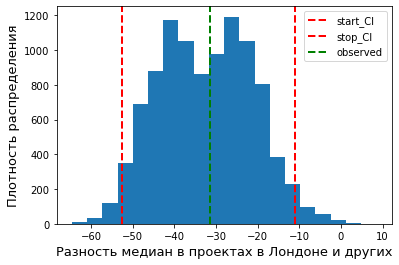

In [67]:
plt.hist(diff_boot, bins = 20);
plt.axvline(ci_left, color='red', linestyle="--", lw=2, label='start_CI')
plt.axvline(ci_right, color='red', linestyle="--", lw=2, label='stop_CI')
plt.axvline(median_hat, color='green', linestyle="--", lw=2, label='observed')
plt.ylabel("Плотность распределения", fontsize=13)
plt.xlabel("Разность медиан в проектах в Лондоне и других", fontsize=13)
plt.legend();

Как видно, ноль не попадает в доверительный интервал, значит, разница между проектами есть, причем интервал явно отрицательный, то есть на самом деле pledge в Лондоне ниже, чем в других проектах. Это может быть объяснено тем, что в Лондоне проживает больше людей, поэтому при поддержке проектов создаются комьюнити с большим количеством человек и каждый должен вкладывать меньше. С другой стороны, жители Лондона могут просто быть эгоистичными и не хотеть инвестировать в частные проекты (учитываем, что далеко не каждый проект предлагает какие-либо награды за участие)

## Гипотеза о матожидании тэга community
Мы предполагаем, что в тэг community люди хотят инвестировать больше, чем во все остальные, так как суть краудфандинга подразумевает создание сообщества

Мы предполагаем в $H_0$, что матожидание проектов с тэгом равно оценке матожидания проектов без него, то есть среднему

$$
\begin{aligned}
& H_0: \mu_{community} = c \\
& H_1: \mu_{community} \not= c
\end{aligned}
$$

Как известно из курса матстата, среднее является наилучшей оценкой для матожидания, поэтому в качестве константы мы решили взять среднее по выборке из проектов без тэга комьюнити. Таким образом, в гипотезе мы проверяем, равно ли матожидание взноса (pledge) группы проектов с тэгом комьюнити среднему для всех остальных проектов. Альтернативной гипотезой является то, что в данный тэг отдельный человек инвестирует в больше. Это может быть объяснимо тем, что люди предпочитают инвестировать в проекты, направленные "на общее благо", такие проект могут казаться более надежными (собранные средства будут использоваться по назначению) и давать людям чувство причастности к общественоо-полезным проектам

В данной гипотезе мы также воспользуемся бутстрап выборкой, но учтем выбросы в данных и построим интервал для математического ожидания одной группы

In [68]:
no_com_av = df[(df['tags_Community'] == 0) & (df['supp'] != 0) & (df['pledge'] < 2000)]['pledge'].mean()
print('Среднее по всем проектам без тэга community равно {:.4f}'.format(no_com_av))
com_av = df[(df['tags_Community'] == 1) & (df['supp'] != 0) & (df['pledge'] < 2000)]['pledge'].mean()
print('Среднее по всем проектам c тэгом community равно {:.4f}'.format(com_av))

Среднее по всем проектам без тэга community равно 210.7264
Среднее по всем проектам c тэгом community равно 263.5511


In [69]:
mean_hat = no_com_av
mean_hat

210.726434592512

In [70]:
com_tag = df[(df['tags_Community'] == 1) & (df['supp'] != 0) & (df['pledge'] < 2000)]['pledge']

In [71]:
x_boot = get_bootstrap_sample(com_tag, B_sample=10**4)
x_boot_m = np.mean(x_boot, axis=0)

In [72]:
ci_right, ci_left = quantile_ci(x_boot_m)
ci_right, ci_left

(240.9395407110255, 286.53747056689616)

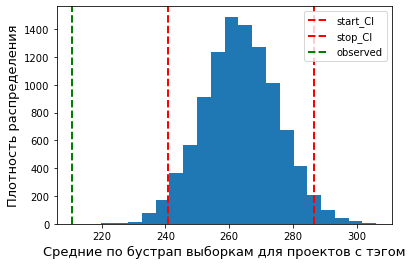

In [73]:
plt.hist(x_boot_m, bins = 20);
plt.axvline(ci_left, color='red', linestyle="--", lw=2, label='start_CI')
plt.axvline(ci_right, color='red', linestyle="--", lw=2, label='stop_CI')
plt.axvline(mean_hat, color='green', linestyle="--", lw=2, label='observed')
plt.ylabel("Плотность распределения", fontsize=13)
plt.xlabel("Средние по бустрап выборкам для проектов с тэгом", fontsize=13)
plt.legend();

Как видно, наше выборочное значение - среднее по проектам без тэга - не попадает в интервал, а он сам лежит правее этого значения, то есть можно сказать, что среднее в выборке с тэгом выше, чем без него. Это подтверждает наше предположение о том, что люди охотнее инвестируют с проекты с тэгом community, чем в остальные

### Количество supporters для национальных проектов в среднем больше, чем для остальных

Мы предполагаем, что количество инвесторов в национальных проектах будет выше, чем во всех остальных. Это связано с тем, что в национальные проекты вкладываются люди со всей страны, тогда как локальные проекты ограничены практически только конкретным городом и его окрестностями. Нулевая гипотеза состоит в равенстве матожиданий в группе, а альтернативная - матожидание национальных проектов выше:

$$
\begin{aligned}
& H_0: \mu_{national} = \mu_{others} \\
& H_1: \mu_{national} > \mu_{others}
\end{aligned}
$$

In [448]:
national = df[(df['location'] == 'United Kingdom') & (df['supp'] != 0) & (df['supp'] < 5000)]['supp']
others = df[(df['location'] != 'United Kingdom') & (df['supp'] != 0) & (df['supp'] < 5000)]['supp']

In [449]:
national.mean()

737.6293706293707

In [450]:
others.mean()

316.78917700112737

Проверим, как распределены выборки с помощью теста Колмагорова:

In [468]:
sts.kstest(national, 'norm')

KstestResult(statistic=0.977671080989349, pvalue=1.5456490049874585e-236)

In [469]:
sts.kstest(others, 'norm')

KstestResult(statistic=0.9845576555196665, pvalue=0.0)

Как видно, они не имеют нормального распределения, но мы можем применить асимптотический ztest для сравнения матожиданий

In [470]:
ztest(national, others, alternative = 'larger')

(7.597557891667468, 1.508856171314472e-14)

Вывод: p-value стремится  к нулю, поэтому, как и ожидалось, нулевая гипотеза отвергается, то есть у национальных проектов действительно больше инвесторов

## Проверка гипотезы о распределении переменной money

Посмотрим на данные без выбросов

In [40]:
money = df[df['money'] < 100000]['money']
sts.kstest(money, 'expon')

KstestResult(statistic=1.0, pvalue=0.0)

In [41]:
money.size # всего наблюдений 1947

1796

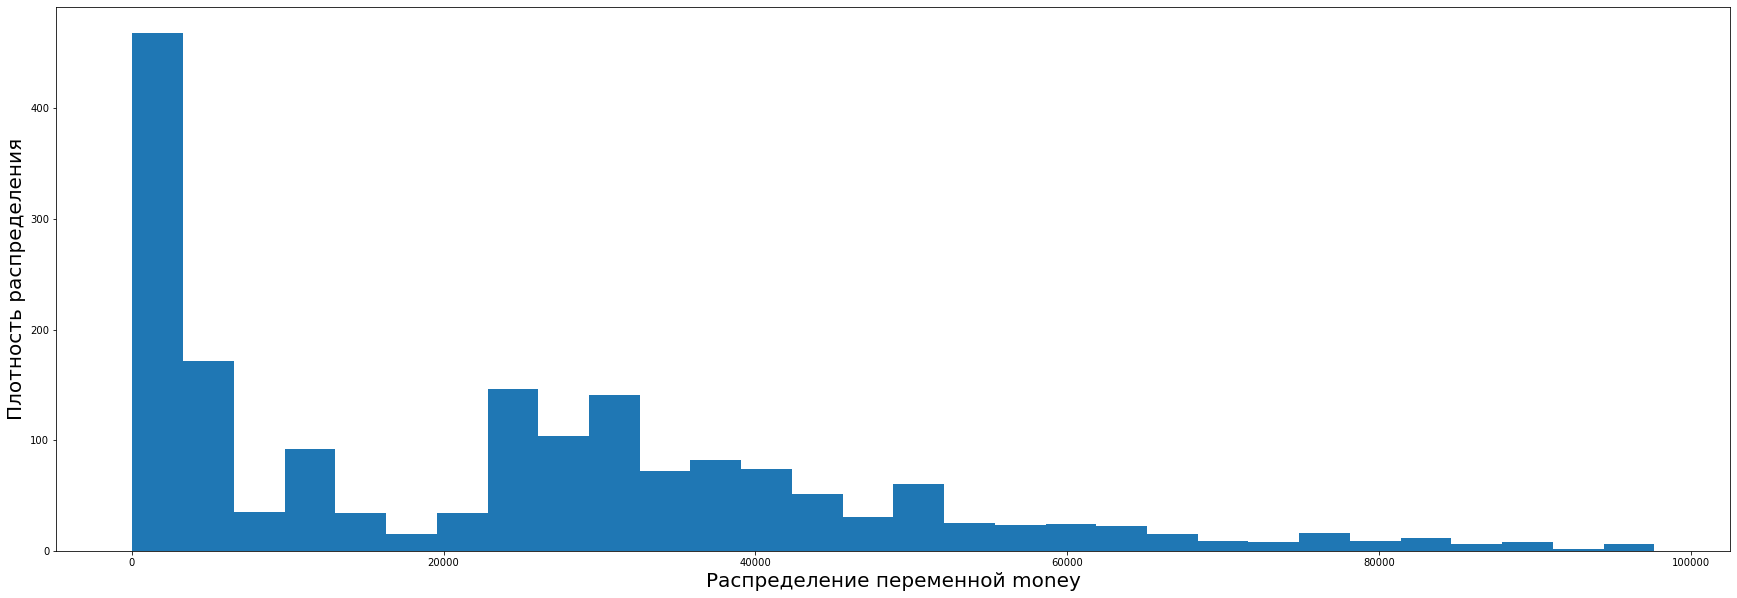

In [80]:
f, ax = plt.subplots(figsize=(30,10))
plt.hist(money, bins=30)
plt.ylabel("Плотность распределения", fontsize=20)
plt.xlabel("Распределение переменной money", fontsize=20);

Как можно увидеть и по тесту, и по гистограмме, предположение об экспоненциальном распределении отвергается, в распределении есть "провалы"

# Выводы

В ходе анализа гипотез мы выявили некоторые закономерности, однако не удалось найти однозначной связи между признаками и средним взносом участника или общей суммой денег

Выявленные связи: 
- есть корреляция между количеством комментариев и собранной суммой денег, причем связь положительная, что может быть объяснено вовлеченностью инвесторов в проект
- в проекты с тэгами отдельный человек инвестирует в среднем больше (pledge выше), так как проект может казаться понятнее и привлекательнее для инвестора
- количество апдейтов и комментариев не связаны
- количество наград не влияет на уровень взноса
- глаголы, побуждающие к действию, не влияют на размер инвестиций
- эмоциональная окраска не влияет на средний взнос 
- расположенные в Лондоне проекты имеют средний взнос ниже, чем остальные, возможно, потому что комьюнити в Лондоне больше и требуется меньший взнос от каждого участника, либо жители Лондона менее заинтересованы инвестировать в общественные проекты
- средний взнос в проектах с тэгом комьюнити выше, чем во всех остальных, вероятно, потому что люди больше заинтересованы инвестировать в проект с таким тэгом
- у национальных проектов больше спонсоров, чем в других проктах, так как инвесторы собираются со всей страны, а не из какой-либо локальной области